# Colour - HDRI - Examples: Merge from Raw Files using Rawpy

Through this example, some Canon EOS 5D Mark II *CR2* images will be merged together in order to create a single HDRI.

The following steps will be taken:

- Creation of an image stack using *CR2* images:
    - Reading of the *CR2* images *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the *CR2* images using [rawpy](https://github.com/neothemachine/rawpy).
- Merging of the image stack into a HDRI.
- Display of the final resulting HDRI.

## Raw Files Filtering

In [1]:
import logging
import os
import rawpy

import colour

from colour_hdri import (
    ROOT_RESOURCES_EXAMPLES,
    Image,
    ImageStack,
    filter_files,
    image_stack_to_HDRI,
    weighting_function_Debevec1997,
)
from colour_hdri.plotting import plot_HDRI_strip

logging.basicConfig(level=logging.INFO)

ROOT_RESOURCES = os.path.join(
    ROOT_RESOURCES_EXAMPLES, "frobisher_001"
)

colour.plotting.colour_style()

colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.12.3 (main, Apr  9 2024, 08:09:14) [Clang 15.0.0           *
*   (clang-1500.3.9.4)]                                                       *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.4.4                                                        *
*       colour-hdri : v0.2.2-38-gd96e78f                                      *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.34.2                                                      *
*       matplotlib : 3.9.0                                                    *
*       networkx : 3.3                  

In [2]:
RAW_FILES = filter_files(ROOT_RESOURCES, ("CR2",))

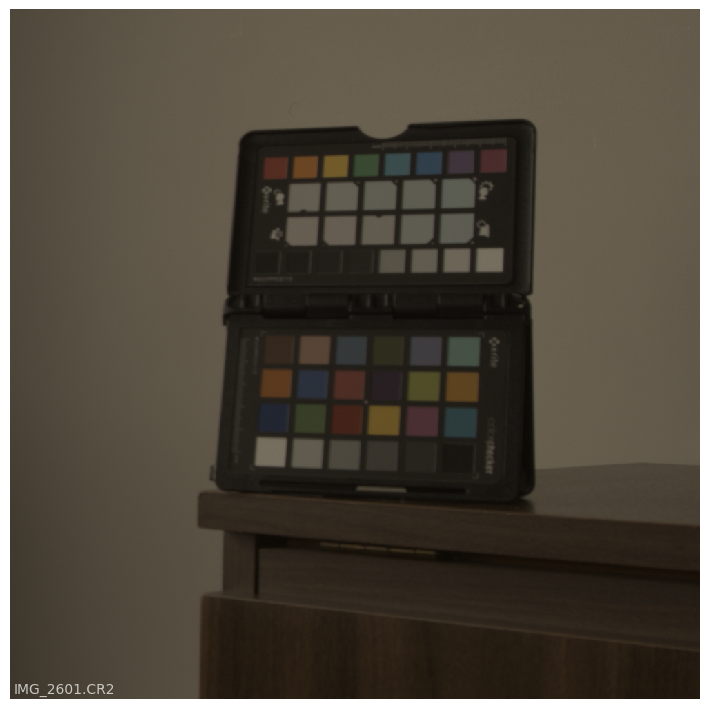

(<Figure size 1280x720 with 1 Axes>, <Axes: >)

In [8]:
def read_raw_file(path):
    raw = rawpy.imread(path).postprocess(
        gamma=(1, 1), no_auto_bright=True, output_bps=16
    )

    return colour.utilities.as_float_array(raw) / 65535


colour.plotting.plot_image(
    colour.cctf_encoding(read_raw_file(RAW_FILES[-2])[1400:2400, 3200:4200, ...]),
    text_kwargs={"text": os.path.basename(RAW_FILES[-2])},
)

## HDRI Merge

In [4]:
def merge_from_raw_files_using_rawpy(
    raw_files,
    output_directory,
    batch_size=5,
    weighting_function=weighting_function_Debevec1997,
):
    paths = []
    for raw_files in colour.utilities.batch(raw_files, batch_size):
        image_stack = ImageStack()
        for raw_file in raw_files:
            image = Image(raw_file)
            image.read_metadata()
            image.data = read_raw_file(raw_file)
            image_stack.append(image)

        path = os.path.join(
            output_directory,
            "{0}_{1}_MRFUR.{2}".format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                "exr",
            ),
        )
        paths.append(path)

        logging.info(f'Merging "{path}"...')
        logging.info(f'\tImage stack "F Number" (Exif): {image_stack.f_number}')
        logging.info(
            f'\tImage stack "Exposure Time" (Exif): {image_stack.exposure_time}'
        )
        logging.info(f'\tImage stack "ISO" (Exif): {image_stack.iso}')
        image = image_stack_to_HDRI(image_stack, weighting_function)

        logging.info(f'Writing "{path}"...')
        colour.write_image(image, path)

    return paths


PATHS = merge_from_raw_files_using_rawpy(RAW_FILES, ROOT_RESOURCES)

INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2598.CR2' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2599.CR2' image EXIF data.
INFO:root:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/resources/colour-hdri-examples-datasets/frobisher_001/IMG_2600.CR2" image metadata.
INFO:root:Reading '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_h

## HDRI Display

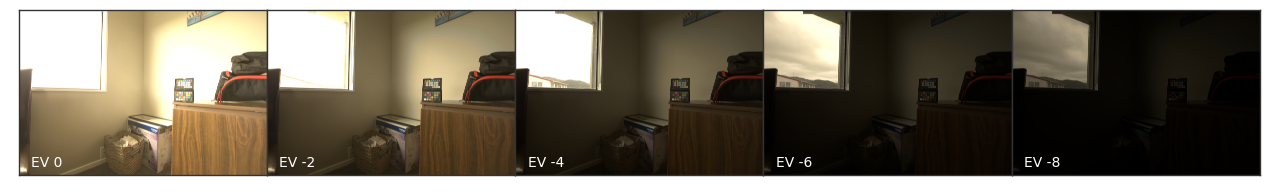

In [5]:
plot_HDRI_strip(colour.read_image(PATHS[0]));